# Choose random sampling of data

In [1]:
import numpy as np
np.set_printoptions(threshold='nan')
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk
import matplotlib 
import matplotlib.pyplot as plt
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
import fnmatch
from sklearn.cluster import KMeans,DBSCAN
import seaborn as sns

"""
============ Start ============

You will be prompted to choose a file. Choose the output file of the quarter you are interested
in that was generated by keplerml.py. This may or may not have the .pkl extension.
"""

print("Choose .pkl output file.")

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
output = askopenfilename() # locate the pickle file with the relevant data
print(output)
if output:
    print("Importing data...")
    pathtofile = os.path.dirname(output)
    outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
    outputdata = []
    # Switched methods of saving data in keplerml.py, the following handles files saved 
    while True:
        try:
            o = pickle.load(outputfile)
        except EOFError:
            break
        else:
            outputdata.append(o)
    outputfile.close()
    
    # Update to keplerml.py saves the output more compactly, following accounts for that
    if len(outputdata)==1:
        outputdata = outputdata[0]

    files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()]
    data = np.array([outputdata[i][1:] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()])
    
    NumLCs = 10000
    print("Choosing %s random files..."%NumLCs)
    randomInds = np.random.choice(range(len(files)), NumLCs, replace=False)

    # test if Tabby star is included in the otherwise random set, insert if not
    print("Checking for Tabby...")
    tabby = fnmatch.filter(files,'*8462852*')
    tabbyInd = files.index(tabby[0])
    npfiles = np.array(files)
    tabbyCheck = fnmatch.filter(npfiles[randomInds], tabby[0])
    
    if tabbyCheck==[]:
        randomInds = np.delete(randomInds,0)
        randomInds = np.insert(randomInds,0,tabbyInd)
    
    filesSample = npfiles[randomInds]
    dataSample = data[randomInds]
    print("Done.")

Choose .pkl output file.
/home/dgiles/Documents/KeplerLCs/output/Q5_output
Importing data...
Choosing 10000 random files...
Checking for Tabby...
Done.


## Apply t-SNE dimensionallity reduction and Plot for review

0.216597273946


<IPython.core.display.Javascript object>


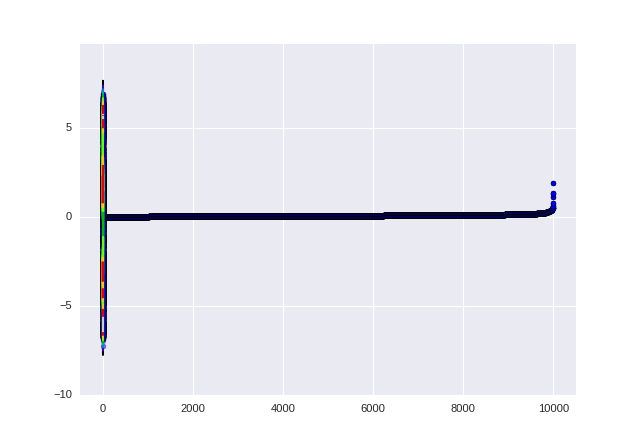

In [8]:
from sklearn.manifold import TSNE
%matplotlib notebook
# Goal is to minimize the kl_divergence, play with perplexity values to find a minimum. 500 seems to be fairly good with Q5
tsne = TSNE(n_components=2,perplexity=500)
tsne_fit=tsne.fit_transform(dataSample)
tsneX=tsne_fit[:,0]
tsneY=tsne_fit[:,1]
print(tsne.kl_divergence_)
dataTSNE = [[filesSample[i],tsne_fit[i][0],tsne_fit[i][1]] for i in range(len(tsne_fit))]
with sns.axes_style("darkgrid"):
    sns.kdeplot(tsneX, tsneY,shade=False,cmap="nipy_spectral")
    plt.scatter(tsneX, tsneY,alpha=.3)

## Save the t-SNE sample output

In [9]:
def file_save(data):
    f = asksaveasfile(mode='w', defaultextension=".pkl")
    if f is None: # asksaveasfile return `None` if dialog closed with "cancel".
        print("Cancelled.")
        return
    pickle.dump(data,f)
    f.close()

file_save(dataTSNE)

# Generate K-means Clusters

In [ ]:
"""
K-Means Clustering
Purpose: Find clusters and their outliers, output the results to np arrays.

Required:
.pkl file produced from keplerml.py.

This was created with the intent to cluster lightcurves based on the features calculated by keplerml.py. However,
the methodology used is general and can be applied to any set of data as long as the data is saved as a pickle file
with the identifier (file name) as the [:,0] index, and the rest of the data for each file as the [:,1:] 
indices.
"""

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
import matplotlib.pyplot as plt
import heapq
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from numpy.random import RandomState
from multiprocessing import Pool
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk

from tkFileDialog import askopenfilename,askdirectory

# Transposition. Will change an array orgnaized by data point (coordinates) to an array organized 
# by feature (list of all values for each feature) and vice versa.
def reorganizeArray(X):
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def bounding_box(X):
    # X is the data that comes in, it's organized by lightcurve[[all features for lc 1],[features for lc2],...]
    # To find minima we need to consider all points for each feature seperate from the other features.
    numFeats = len(X[0])
    Xbyfeature = reorganizeArray(X)

    # xmin/xmax will be an array of the minimum/maximum values of the features
    xmin=[]
    xmax=[]
    # Create the minimum vertex, and the maximum vertex for the box
    for feature in range(numFeats):
        xmin.append(min(Xbyfeature[feature]))
        xmax.append(max(Xbyfeature[feature]))
        
    return (xmin,xmax)

def KMeans_clusters(data,nclusters):
    # Run KMeans, get clusters
    npdata = np.array(data)
    est = KMeans(n_clusters=nclusters)
    est.fit(npdata)
    clusters = est.labels_
    centers = est.cluster_centers_
    return clusters, centers

def seperatedClusters(data,nclusters,clusters):
    """
    Args:
    data - all data, organized by lightcurve 
    nclusters - number of clusters
    clusters - cluster labels
    
    Purpose: Create arrays dataByCluster and clusterIndexes containing data seperated by
    by cluster.
    """
    dataByCluster = []
    clusterIndexes = []
    
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
        # Keeping track of which points get pulled into each cluster:
        clusterIndexes.append([j for j in range(len(data)) if clusters[j]==i])
        # Separating the clusters out into their own arrays (w/in the cluster array)
        dataByCluster.append([data[clusterIndexes[i][j]] for j in range(len(clusterIndexes[i]))])
        
    return dataByCluster, clusterIndexes

def distances(pointsForDistance,referencePoint):
    """
    Args:
    cluster/pointsForDistance - array of any number of points, each point an array of it's features
    centerloc/referencePoint - array of the features for a single point
    
    Purpose: 
    This will calculate the distances of a group of points to a given point.
    I should change the reference point to the center of the cluster rather than the point closest to the center.
    
    """
    distFromCenter = [0 for j in range(len(pointsForDistance))] # reinitializing for each cluster
    # loop for each lightcurve of the cluster
    for j in range(len(pointsForDistance)):
        dataloc=pointsForDistance[j] # coordinates of the datapoint
        sqrd=0
        # loop for each feature of the lightcurve 
        for k in range(len(referencePoint)):
            sqrd+=pow(dataloc[k]-referencePoint[k],2) # (x-x0)^2+(y-y0)^2+...
        distance = pow(sqrd,0.5) # sqrt((x-x0)^2+(y-y0)^2+...)
        distFromCenter[j]=distance 
    return distFromCenter

def beyondCutoff(cutoff,distances):
    """
    returns: outliers and typical arrays
        outlier array contains indexes of the specific cluster array that are beyond the cutoff
        typical array contains single index of the cluster array that is nearest the center
    
    Args:
    cutoff - a number, everything beyond this number is considered an outlier
    distances - array containing distances to each lightcurve point from the center for a given cluster
    """
    outliers=[j for j in range(len(distances)) if distances[j]>=cutoff] # recalculated for each cluster
    typical=[j for j in range(len(distances)) if distances[j]==min(distances)]
    return outliers,typical

def outliers(data,clusters,centers,files):
    """
    Args:
    data - all the data
    clusters - the cluster labels from kmeans. DBSCAN will require different methodology
    centers - locations of the cluster centers
    
    Purpose:
    Separate out the data on the edge of the clusters which are the most likely anomalous data.
    
    """
    
    nclusters = len(centers)

    # Sanity check, if this isn't an outlier than something is wrong.
    """
    controlPoint = np.array([10000 for i in range(len(data[0]))])
    
    data=np.append(data,[controlPoint],axis=0)
    clusters=np.append(clusters,[1],axis=0)
    """
    
    """
    Initializing arrays
    """
    
    cluster, clusterIndexes = seperatedClusters(data,nclusters,clusters)
    clusterIndexes = np.array(clusterIndexes)
    twoSigma = [] #probably doesn't need an array 
    distFromCenter = []
    allTypical=[]
    allOutliers=[]
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
                
        """
        ========== Checking density of clusters ============
        Given that some of the clusters may have 0 spread in a given feature, I'm not confident that this is meaningful,
        but there's a chance this can give insight into potentially outlying clusters (clusters of misfits)
        """
        """
        (xmin,xmax)=bounding_box(cluster[i]) # get the minimum and maximum values for both
        
        diff=[xmax[n]-xmin[n] for n in range(len(xmin))]
        volOfClusterBB=1.0
        for n in diff:
            if n!=0:
                volOfClusterBB*=n
        densOfCluster=len(cluster[i])/volOfClusterBB
        """
        """
        print("Cluster: %s, Density: %s" %(i,densOfCluster))
        print volOfClusterBB
        """
        
        """
        ========== Finding points outside of the cutoff ===========
        """
        # not currently using this cutoff.
        twoSigma.append(2*np.std(cluster[i]))
        
        """
            ==== Calculating distances to each point ====
        """
        # Calculate distances to each point in each cluster to the center of its cluster
        distFromCenter.append(distances(cluster[i],centers[i]))
        
        """
            ==== Finding outliers and the standard (defined by the closest to the center) ====
        """
        cutoff=.5*max(distFromCenter[i])
        # Will implement a better cutoff.
        
        # returns cluster indices of the outliers and the typical lcs
        outliers,typical = beyondCutoff(cutoff,distFromCenter[i])
        
        # Add typical lightcurve to list. Only 1 produced at present, but this may change. The following
        # accounts for adding more typicals later.
        clusterIndexes[i] = np.array(clusterIndexes[i])
        allTypical.append(clusterIndexes[i][typical])
            
        # place outliers from this cluster into general outlier list
        allOutliers.append(clusterIndexes[i][outliers])
        
    return allOutliers,allTypical

"""
============ Start ============
"""
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
output = askopenfilename() # locate the pickle file with the relevant data

if output:
    
    pathtofile = os.path.dirname(output)
    outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
    outputdata = []
    while True:
        try:
            o = pickle.load(outputfile)
        except EOFError:
            break
        else:
            outputdata.append(o)
    outputfile.close()
    if len(outputdata) == 1:
        outputdata = outputdata[0]

    files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()]
    data = np.array([outputdata[i][1:] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()])
    
    # nclusters can be obtained through the optimalK.py script 
    nclusters = int(raw_input('Enter the number of clusters expected: '))

    clusterLabels,centers=KMeans_clusters(data,nclusters)
    dataByCluster,clusterIndexes = seperatedClusters(data,nclusters,clusterLabels)
    outliers,typical=outliers(data,clusterLabels,centers,files)
    
    """
    Saving all cluster output in a single pickle file.
    format: [filename array,cluster label array,data array array]
    """
    clusterLabels = clusterLabels+1
    for i in typical:
        clusterLabels[i] = 0
    nclusters = max(clusterLabels)
    for i in outliers:
        clusterLabels[i] = nclusters+1

    clusteroutputarray = [files,clusterLabels,data]
    clusteroutput = pathtofile+'/'+raw_input('Save as: ')+'.pkl'
    # Tests to see if output has been created previously. Allows the user to replace the existing cluster data or abort.
    if os.path.isfile(clusteroutput):
        while os.path.isfile(clusteroutput):
            replace = raw_input('Cluster output file exists, replace? (y/n) ')
            if replace == 'y':
                break
            elif replace == 'n':
                clusteroutput = pathtofile+'/'+raw_input('Enter new file name: ')+'.pkl'
            else:
                while(replace!=('y' or 'n')):
                    replace = raw_input("Invalid response (y/n): ")
    else:
        open(clusteroutput,'a').close()
    clusterfile = open(clusteroutput,'r+')
    pickle.dump(clusteroutputarray,clusterfile)
    clusterfile.close()
    print("Done.")

# DBSCAN Epsilon Estimation

<IPython.core.display.Javascript object>


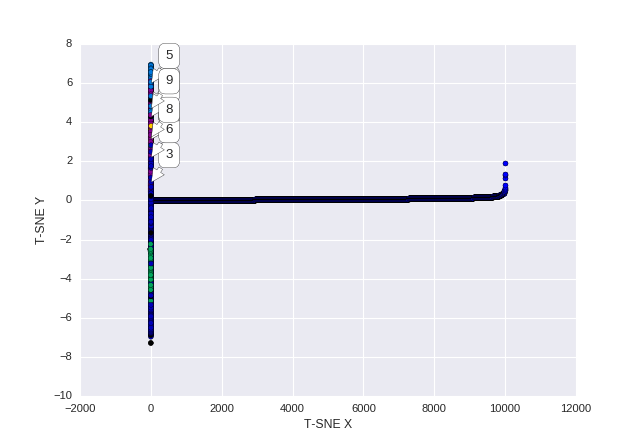

In [11]:
"""
The suggested 'heuristic' from the original DBSCAN paper to determine a ballpark for epsilon.
Plots the distances from a center point (in this case we consider the center point of the clusters found through kmeans)
sorted by distance. The 'elbow' gives the cutoff between cluster points and noise/outliers.

I think this could just be applied directly to the kmeans clusters to determine the cutoff for each cluster. Though it's 
not obvious how to automate finding the bend.
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.neighbors import NearestNeighbors

"""--- Importing the relevant data ---"""
data = tsne_fit

"""for f in outlierfiles:
    outlierIndices.append(files.index(f))"""

if __name__ == '__main__':
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    distArr = distances[:,3]
    distArr.sort()
    pts = [i for i in range(len(distArr))]

    plt.scatter(pts, distArr)

    plt.show()


In [22]:
dx,dy,xofslope,slope=[],[],[],[]
for i in range(len(data)-1):
    dx.append(data[i+1,0]-data[i,0])
    dy.append(data[i+1,1]-data[i,1])
    xofslope.append(dx[i]/2+data[i])
    slope.append(dy[i]/dx[i])

plt.scatter(xofslope,slope)
plt.show()

ValueError: x and y must be the same size

# Import (kmeans) or generate (DBSCAN) clusters

In [1]:
""" 
This will plot individual clusters into a 3D scatter and on choosing (clicking on) a point, 
plot the point's associated lightcurve. The 3 axes will be selectable via radiobuttons.

This may be applied to any scatter of data with associated lightcurves (assuming the 
lightcurve data is available and the filelist appropriately named).

TODO: Make this general, plot DBSCAN or KMeans generated clusters.
Want to plot uniquely for Kmeans and DBSCAN

Requirements:
Filelist - Containing file names of the lightcurve data for the cluster
Data file - numpy array containing calculated features for each lightcurve
Optional:
Outlier filelist - contains the file names for the outliers and the typical* lightcurve. 
    The typical lightcurve must be on line number 1.

*typical as defined by closest to the center of the cluster


Example file list:
    Name: exfilelist
    Content:
    lightcurve1_llc.fits
    lightcurve2_llc.fits
    lightcurve3_llc.fits

Note: There can be no blank lines in the filelist.

Example numpy file:
    Name: exdataByLightCurve.npy
    Content (when read-in by np.load()):
    [[data for lightcurve1]
     [data for lightcurve2]
     [data for lightcurve3]]
 
Note: The filelist and the .npy must have the above fromat and must be organized in the same way,
e.g. the first index of the array corresponds to the first line of the filelist.

filelist: identifier+'filelist'    npy: identifier+'dataByLighCurve.npy'
In the example above the identifier was 'ex'.
"""
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
from sklearn.cluster import DBSCAN
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
from numbapro import cuda
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory

root = Tk.Tk()
root.wm_title("Scatter")

def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    
    return clusters, coreSampleIndices

def loadfile(filename):
    pathtofile = os.path.dirname(filename)
    f = open(filename,'r+') # show an "Open" dialog box and return the path to the selected file
    data = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        else:
            data.append(o)
    f.close()
    
    if len(data) == 1:
        data = data[0]
        
    return data

@cuda.autojit
def clusterIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]!=0 and clusterLabels[i]<outs:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
@cuda.autojit
def centerIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]==0:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
@cuda.autojit
def outlierIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]==outs:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
        
"""--- Importing the relevant data ---"""
clusterType = raw_input('Which clustering method (kmeans or dbscan)? ')
if clusterType == 'KMeans' or clusterType == 'kmeans' or clusterType == 'Kmeans': 
    Tk.Tk.withdraw(root)
    print("Choose the directory the cluster data is contained in.")
    pathtofile = askopenfilename() # Choose the cluster file
    openclusterfile = open(pathtofile,'r+')
    print("Importing pickle file...")
    clusterfile = pickle.load(openclusterfile)
    print("File imported")
    openclusterfile.close()
    files = np.array(clusterfile[0])
    clusterLabels = np.array(clusterfile[1])
    data = np.array(clusterfile[2])
    
    clusterIndices = []
    outlierIndices = []
    centerIndices = []
    print("Seperating into clusters, outliers, and centers...")
    
    ### Start Cuda GPU Stuff ###
    outs=max(clusterLabels)
    N=len(clusterLabels)
    # Send clusterLabels to gpu
    d_clusterLabels = cuda.to_device(clusterLabels)
    # Create array for cluster indexes
    clusterIndices = np.empty(N)
    d_clusterIndices=cuda.to_device(clusterIndices)
    d_centerIndices=cuda.to_device(clusterIndices)
    d_outlierIndices=cuda.to_device(clusterIndices)
    N=len(clusterLabels)
    threads_per_block = 128
    number_of_blocks =N/128+1

    clusterIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_clusterIndices)
    centerIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_centerIndices)
    outlierIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_outlierIndices)
    
    clusterIndices = d_clusterIndices.copy_to_host()
    clusterIndices = [int(clusterIndices[i]) for i in range(len(clusterIndices)) if clusterIndices[i]<(N+1)]
    centerIndices = d_centerIndices.copy_to_host()
    centerIndices = [int(centerIndices[i]) for i in range(len(centerIndices)) if centerIndices[i]<(N+1)]
    outlierIndices = d_outlierIndices.copy_to_host()
    outlierIndices = [int(outlierIndices[i]) for i in range(len(outlierIndices)) if outlierIndices[i]<(N+1)]

    
    # print("Seperated, choosing random cluster points to display...")
    # I don't think anyone has a real interest in seeing hundreds of thousands of 'normal' points, choosing a random sampling
    # TODO: use density estimation to display all data
    # randomClusterIndices = np.random.choice(clusterIndices,1000,replace=False)
    print("Reforming data arrays...")
    inds = np.append(clusterIndices,outlierIndices)
    inds = np.append(inds,centerIndices)
    inds = [i for i in inds if i!=None]
    files = files[inds]
    clusterLabels = clusterLabels[inds]
    data = data[inds]
    plotArray = [files,clusterLabels,data]
    print("Plot in next cell.")
    
elif clusterType == 'DBSCAN' or clusterType =='dbscan':
    
    Tk.Tk.withdraw(root) # we don't want a full GUI, so keep the root window from appearing
    output = askopenfilename() # locate the pickle file with the relevant data
    if output:
        print("Loading file...")
        outputdata = loadfile(output)

        files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any()]
        data = np.array([outputdata[i][1:] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any()])
        
        # nclusters can be obtained through the optimalK.py script 
        print("Clustering data...")
        clusterLabels,coreSampleIndices = DBSCAN_clusters(data,.24,10)
        plotArray = [files,clusterLabels,data]
        print("Sorting...")
        centerIndex=coreSampleIndices[0]
        outlierIndices = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
        outlierFiles = [files[i] for i in outlierIndices]
        numClusters = max(clusterLabels)
        colorLabels = ['b' for k in range(len(files))]
        for i in outlierIndices:
            colorLabels[i] = 'r'
        for i in coreSampleIndices:
            colorLabels[i] = 'g'
        print("Done.")

else:
    print("Only KMeans and DBSCAN are compatible with this program at this time.")
    sys.exit()

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


Which clustering method (kmeans or dbscan)? dbscan
Loading file...
Clustering data...
Sorting...
Done.


In [14]:
import fnmatch
tabby = fnmatch.filter(outlierFiles,'*8462852*')
print tabby

[]


# Plot clusters (must be generated above)

In [15]:

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.figure import Figure
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory
from numbapro import cuda


root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = plotArray[0]
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    data = plotArray[2]
    # tsneX has all the x-coordinates
    tsneX = data[:,0]
    # tsneY has all the y-coordinates
    tsneY = data[:,1]
    
    filesWpath = [pathtofits+files[i] for i in range(len(files))]
    numcpus = cpu_count()
    usecpus = numcpus*4
    p = Pool(usecpus)
    lc = p.map(read_kepler_curve,filesWpath)
    p.close()
    p.join()
    t=[lc[i][0] for i in range(len(lc))]
    nf=[lc[i][1] for i in range(len(lc))]
    del(lc)
    lightcurveData=np.array([t,nf])
    del(t)
    del(nf)
    del(numcpus)
    del(usecpus)
    del(filesWpath)
    """--- Organizing data and Labels ---"""
        
    fig = Figure()
    
    # a tk.DrawingArea
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    # empty subplot for scattered data
    ax = fig.add_subplot(211)
    plt.subplots_adjust(left=0.3)
    #ax.mouse_init()
    
    # empty subplot for lightcurves
    ax2 = fig.add_subplot(212)
    
    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (2,), "distance: point.shape is wrong: %s, must be (2,)" % point.shape
        x2,y2 = ax.transData.transform((point[0],point[1]))

        return np.sqrt ((x2 - event.x)**2 + (y2 - event.y)**2)
    
    def calcClosestDatapoint(XT, event):
        """"Calculate which data point is closest to the mouse position.
        
        Args:
            XT (np.array) - array of points, of shape (numPoints, 2)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (XT[:,i], event) for i in range(XT.shape[1])]
        
        return np.argmin(distances)
    
    def drawData(X, index):
        # Plots the lightcurve of the point chosen
        ax2.cla()

        x=lightcurveData[0][index]
        y=lightcurveData[1][index]
        
        axrange=0.55*(max(y)-min(y))
        mid=(max(y)+min(y))/2
        yaxmin = mid-axrange
        yaxmax = mid+axrange
        ax2.set_ylim(yaxmin,yaxmax)

        ax2.scatter(x, y, 'o',markeredgecolor='none', c="black", alpha=0.2)
        ax2.scatter(x, y, '-',markeredgecolor='none', c="black", alpha=0.7)

        canvas.draw()
        
    def annotateCenter(XT, index):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        x2, y2 = XT[index][0], XT[index][1]
        # Either update the position, or create the annotation
        if hasattr(annotateCenter, 'label'):
            annotateCenter.label.xy = x2,y2
            annotateCenter.label.update_positions(fig.canvas.renderer)
        # Get data point from array of points X, at position index
        else:
            annotateCenter.label = ax.annotate( "%s" % files[index],
                xy = (x2, y2), xytext = (40, 40), textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'g', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
        canvas.draw()
    
    
    def onMouseClick(event, X):
        """Event that is triggered when mouse is clicked. Shows lightcurve for data point closest to mouse."""
        XT = np.array(reorganizeArray(X)) # array organized by feature, each in it's own array
        closestIndex = calcClosestDatapoint(XT, event)
        print("Mouse clicked near %s"%closestIndex)
        drawData(lightcurveData, closestIndex)
        
    def onMouseRelease(event, X):
        XT = np.array(reorganizeArray(X))
        annotateCenter(XT,-1)
        #for centerIndex in centerIndices:
        #    annotateCenter(XT,centerIndex)
    
    def connect(X):
        """
        TODO: Limit it to being connected only when in axes.
        ISSUE: Double connects when replotted. Doesn't seem to want to disconnect.
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
            connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
            connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))
        """
        if hasattr(connect,'cidpress'):
            fig.canvas.mpl_disconnect(connect.cidpress)
        if hasattr(connect,'cidrelease'):
            fig.canvas.mpl_disconnect(connect.cidrelease)
        connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
        #connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))

    def disconnect(event):
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
    
    def redraw():       
        # Clear the existing plots
        ax.cla()
        ax2.cla()        
        # Set those labels
        ax.set_xlabel("T-SNE X")
        ax.set_ylabel("T-SNE Y")
        # Scatter the data
        ax.scatter(tsneX, tsneY,c=clusterLabels,cmap='nipy_spectral')
        
        annotateCenter(data,-1)
        #for centerIndex in centerIndices:
        #    annotateCenter(currentData1,centerIndex)
        
        if hasattr(redraw,'cidenter'):
                fig.canvas.mpl_disconnect(redraw.cidenter)
                fig.canvas.mpl_disconnect(redraw.cidexit)
        connect(data)
        #cidenter = fig.canvas.mpl_connect('axes_enter_event', lambda event: connect(event,currentData))
        #cidexit = fig.canvas.mpl_connect('axes_leave_event', lambda event: disconnect(event))
        canvas.draw()

    redraw() # First draw
    Tk.Tk.deiconify(root)
    canvas.show()
    
    def quit():
        root.destroy()
        sys.exit()
        
    Tk.Button(root, text="Quit", command=quit).pack()
    
root.mainloop()

Choose the directory that the fits files are contained in.
Mouse clicked near 7390


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/dgiles/anaconda/lib/python2.7/lib-tk/Tkinter.py", line 1536, in __call__
    return self.func(*args)
  File "/home/dgiles/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_tkagg.py", line 405, in button_press_event
    FigureCanvasBase.button_press_event(self, x, y, num, dblclick=dblclick, guiEvent=event)
  File "/home/dgiles/anaconda/lib/python2.7/site-packages/matplotlib/backend_bases.py", line 1903, in button_press_event
    self.callbacks.process(s, mouseevent)
  File "/home/dgiles/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py", line 563, in process
    proxy(*args, **kwargs)
  File "/home/dgiles/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py", line 430, in __call__
    return mtd(*args, **kwargs)
  File "<ipython-input-15-a0dfb1ffade4>", line 193, in <lambda>
    connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
  Fil

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [16]:
print(len(lightcurveData[1][7390]))

4486


Choose the directory that the fits files are contained in.


<IPython.core.display.Javascript object>


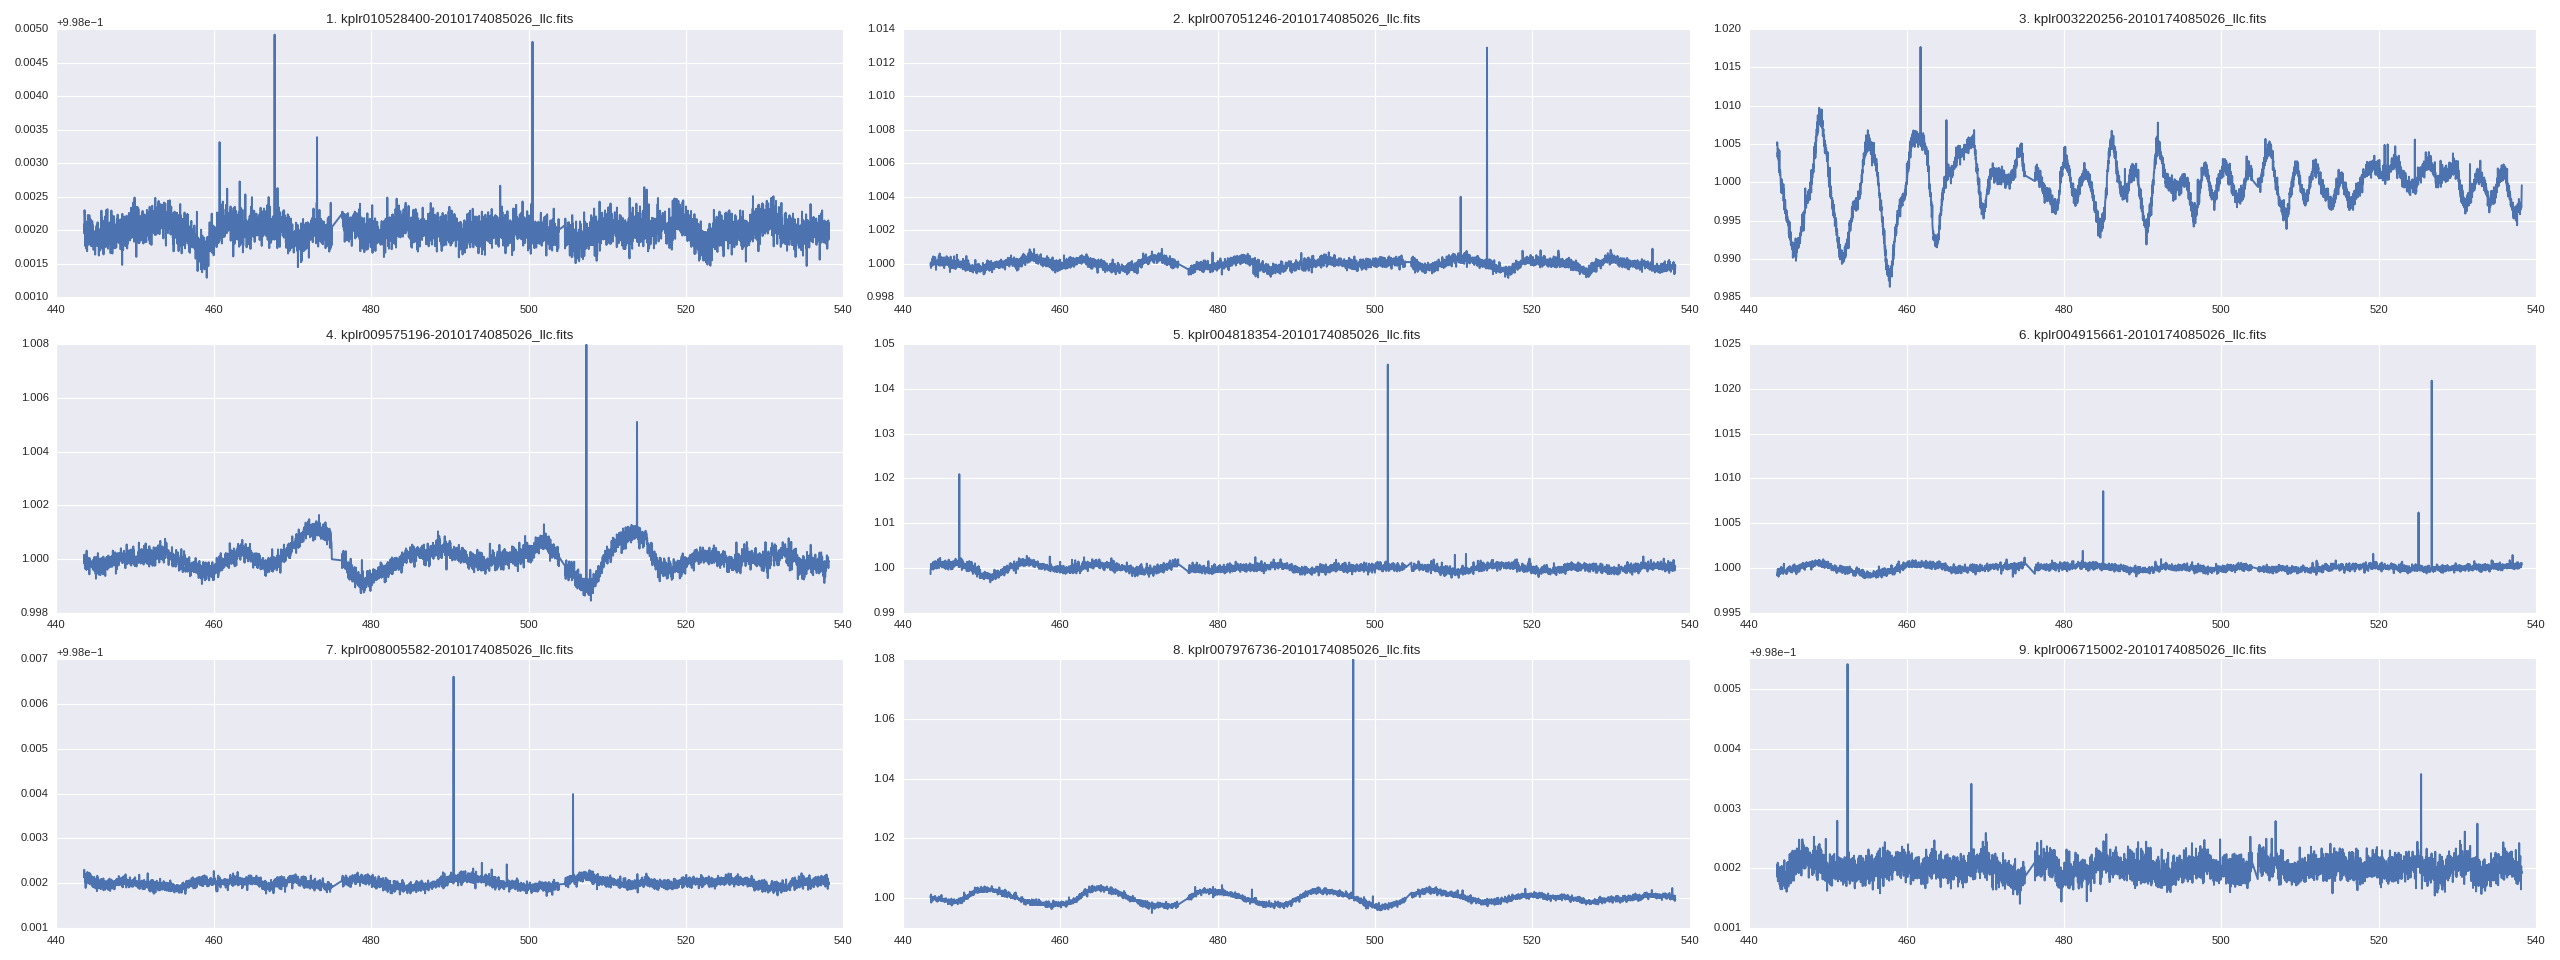

In [15]:

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.figure import Figure
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory
from numbapro import cuda

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

def plotstuff(cluster):
    tarr=[]
    nfarr=[]
    
    for j in filesByCluster[cluster]:
        t,nf,err = read_kepler_curve(pathtofits+j)
        tarr.append(t)
        nfarr.append(nf)
    
    """--- Organizing data and Labels ---"""
    # empty subplots for lightcurves
    ax1 = plt.subplot(331)
    ax1.plot(tarr[randomInds[cluster][0]],nfarr[randomInds[cluster][0]])
    ax1.set_title('1. '+filesByCluster[cluster][randomInds[cluster][0]])
    ax2 = plt.subplot(332)
    ax2.plot(tarr[randomInds[cluster][1]],nfarr[randomInds[cluster][1]])
    ax2.set_title('2. '+filesByCluster[cluster][randomInds[cluster][1]])
    ax3 = plt.subplot(333)
    ax3.plot(tarr[randomInds[cluster][2]],nfarr[randomInds[cluster][2]])
    ax3.set_title('3. '+filesByCluster[cluster][randomInds[cluster][2]])
    ax4 = plt.subplot(334)
    ax4.plot(tarr[randomInds[cluster][3]],nfarr[randomInds[cluster][3]])
    ax4.set_title('4. '+filesByCluster[cluster][randomInds[cluster][3]])
    ax5 = plt.subplot(335)
    ax5.plot(tarr[randomInds[cluster][4]],nfarr[randomInds[cluster][4]])
    ax5.set_title('5. '+filesByCluster[cluster][randomInds[cluster][4]])
    ax6 = plt.subplot(336)
    ax6.plot(tarr[randomInds[cluster][5]],nfarr[randomInds[cluster][5]])
    ax6.set_title('6. '+filesByCluster[cluster][randomInds[cluster][5]])
    ax7 = plt.subplot(337)
    ax7.plot(tarr[randomInds[cluster][6]],nfarr[randomInds[cluster][6]])
    ax7.set_title('7. '+filesByCluster[cluster][randomInds[cluster][6]])
    ax8 = plt.subplot(338)
    ax8.plot(tarr[randomInds[cluster][7]],nfarr[randomInds[cluster][7]])
    ax8.set_title('8. '+filesByCluster[cluster][randomInds[cluster][7]])
    ax9 = plt.subplot(339)
    ax9.plot(tarr[randomInds[cluster][8]],nfarr[randomInds[cluster][8]])
    ax9.set_title('9. '+filesByCluster[cluster][randomInds[cluster][8]])
    
    plt.tight_layout()
    
if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = plotArray[0]
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    data = plotArray[2]
    # tsneX has all the x-coordinates
    tsneX = data[:,0]
    # tsneY has all the y-coordinates
    tsneY = data[:,1]
    
    filesByCluster = [[files[i] for i in range(len(clusterLabels)) \
                    if clusterLabels[i]==j] for j in range(-1,max(clusterLabels)+1)]
    
    randomInds = []
    for i in range(max(clusterLabels)+1):    
        if len(filesByCluster[i])>=9:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=False))
        else:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=True))
    cluster = 1      
    plotIndices = []
    indDict = {}
    for i in range(9):
        fileInd = files.index(filesByCluster[cluster][randomInds[cluster][i]])
        plotIndices.append(fileInd)
        indDict[fileInd] = i+1
    """--- Organizing data and Labels ---"""
    # empty subplot for scattered data
    fig1 = plt.figure(1,figsize=(24, 24))
    ax = plt.subplot()
        
    def annotatePoint(XT, index,ind):
        x2, y2 = XT[index][0], XT[index][1]
        annotatePoint.label = ax.annotate( "%s" %ind,
            xy = (x2, y2), xytext = (20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 1),
            arrowprops = dict(facecolor='white',shrink=0.05,connectionstyle = 'arc3,rad=0.0'))
        
    def redraw():           
        # Set those labels
        ax.set_xlabel("T-SNE X")
        ax.set_ylabel("T-SNE Y")
        # Scatter the data
        ax.scatter(tsneX, tsneY,c=clusterLabels,cmap='nipy_spectral')
        
        for Index in plotIndices:
            annotatePoint(data, Index,indDict[Index])
        
    redraw() # First draw
    
    fig2 = plt.figure(2, figsize=(32, 12)) 
    plotstuff(0)
    plt.show()    

In [84]:
print(filesByCluster[cluster][randomInds[0][0]])

kplr002448534-2010078095331_llc.fits


Choose the directory that the fits files are contained in.


<IPython.core.display.Javascript object>


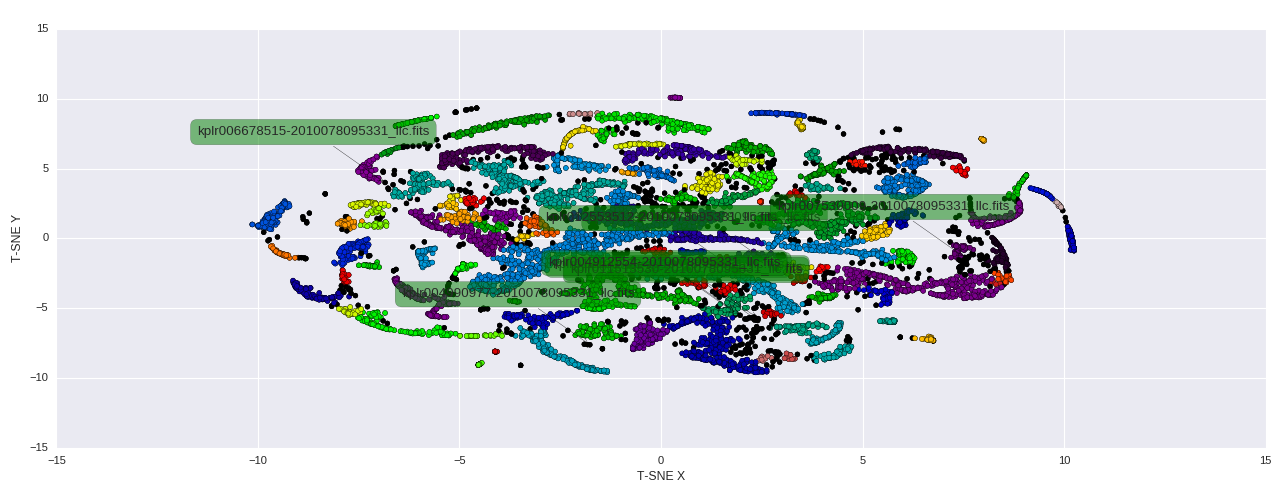

<IPython.core.display.Javascript object>


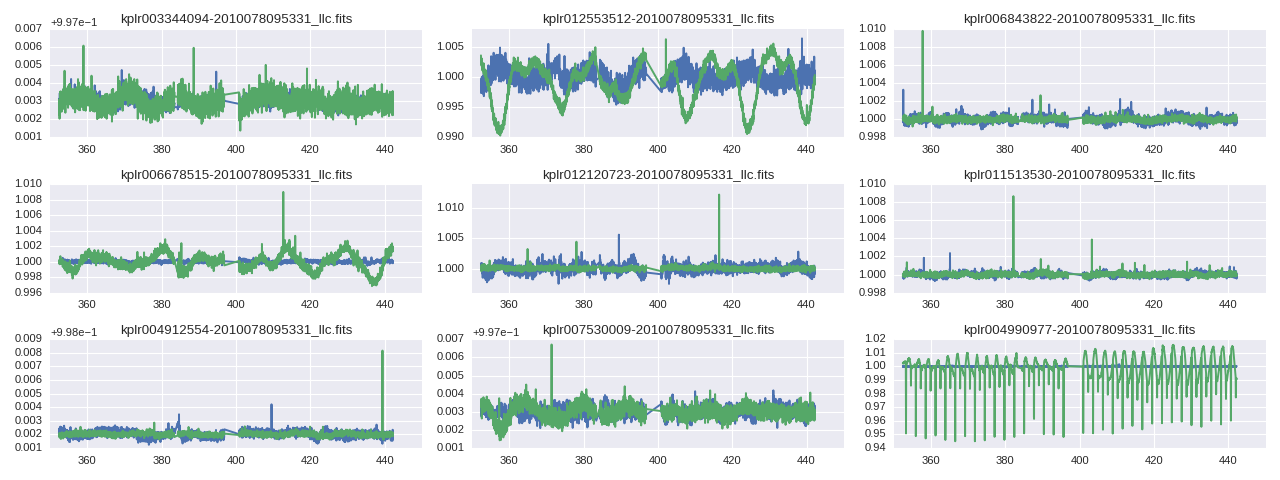

In [73]:
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory

root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

def plotstuff(cluster):
    tarr=[]
    nfarr=[]
    
    for j in filesByCluster[cluster]:
        t,nf,err = read_kepler_curve(pathtofits+j)
        tarr.append(t)
        nfarr.append(nf)
    
    """--- Organizing data and Labels ---"""
    # empty subplots for lightcurves
    ax1 = plt.subplot(331)
    ax1.plot(tarr[randomInds[cluster][0]],nfarr[randomInds[cluster][0]])
    ax1.set_title(filesByCluster[cluster][randomInds[cluster][0]])
    ax2 = plt.subplot(332)
    ax2.plot(tarr[randomInds[cluster][1]],nfarr[randomInds[cluster][1]])
    ax2.set_title(filesByCluster[cluster][randomInds[cluster][1]])
    ax3 = plt.subplot(333)
    ax3.plot(tarr[randomInds[cluster][2]],nfarr[randomInds[cluster][2]])
    ax3.set_title(filesByCluster[cluster][randomInds[cluster][2]])
    ax4 = plt.subplot(334)
    ax4.plot(tarr[randomInds[cluster][3]],nfarr[randomInds[cluster][3]])
    ax4.set_title(filesByCluster[cluster][randomInds[cluster][3]])
    ax5 = plt.subplot(335)
    ax5.plot(tarr[randomInds[cluster][4]],nfarr[randomInds[cluster][4]])
    ax5.set_title(filesByCluster[cluster][randomInds[cluster][4]])
    ax6 = plt.subplot(336)
    ax6.plot(tarr[randomInds[cluster][5]],nfarr[randomInds[cluster][5]])
    ax6.set_title(filesByCluster[cluster][randomInds[cluster][5]])
    ax7 = plt.subplot(337)
    ax7.plot(tarr[randomInds[cluster][6]],nfarr[randomInds[cluster][6]])
    ax7.set_title(filesByCluster[cluster][randomInds[cluster][6]])
    ax8 = plt.subplot(338)
    ax8.plot(tarr[randomInds[cluster][7]],nfarr[randomInds[cluster][7]])
    ax8.set_title(filesByCluster[cluster][randomInds[cluster][7]])
    ax9 = plt.subplot(339)
    ax9.plot(tarr[randomInds[cluster][8]],nfarr[randomInds[cluster][8]])
    ax9.set_title(filesByCluster[cluster][randomInds[cluster][8]])
    
    plt.tight_layout()
    
if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = plotArray[0]
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    # data = plotArray[2]

    # dataByCluster = np.array([data[i] for i in range(max(clusterLabels)) if clusterLabels[i]==i])
    filesByCluster = [[files[i] \
                        for i in range(len(clusterLabels)) \
                    if clusterLabels[i]==j]\
                for j in range(-1,max(clusterLabels)+1)]
    randomInds = []
    for i in range(max(clusterLabels)+1):    
        if len(filesByCluster[i])>=9:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=False))
            # Returns array with 9 random indices
        else:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=True))
    fig1 = plt.figure(1, figsize=(16, 6)) 
    plt.title("Outlier Samples")
    plotstuff(0)
    fig2 = plt.figure(2, figsize=(16, 6))
    plt.title("Cluster 1 Samples")
    plotstuff(2)
    plt.show()